##سوال 3

In [ ]:
import gdown
file_id = "1FLnmdS-GTgRvtvYFis17noFhNO43RHst"
output_file = "ballbeam.dat"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From: https://drive.google.com/uc?id=1FLnmdS-GTgRvtvYFis17noFhNO43RHst
To: /content/ballbeam.dat
100%|██████████| 35.0k/35.0k [00:00<00:00, 18.3MB/s]


'ballbeam.dat'

In [ ]:
import pandas as pd

data = pd.read_csv('/content/ballbeam.dat')

print(data)

       -1.9634990e-03\t  -4.8851980e-03\t
0      -1.9634990e-03\t  -4.6409380e-03\t
1      -1.9634990e-03\t  -3.7860280e-03\t
2      -1.9634990e-03\t  -4.0302880e-03\t
3      -1.9634990e-03\t  -3.9081580e-03\t
4      -1.9634990e-03\t  -1.9540790e-03\t
..                                    ...
994    -9.3266150e-03\t  -3.2364440e-02\t
995    -1.2271860e-02\t  -2.6257940e-02\t
996    -1.4726230e-02\t  -1.7342450e-02\t
997    -1.6689720e-02\t  -1.2945770e-02\t
998    -1.8653220e-02\t  -6.1064970e-03\t

[999 rows x 1 columns]


Starting PyTorch-based processing...
Raw data shape: (1000, 2)
Windowed input shape: (997, 3)
Windowed target shape: (997,)
Epoch [1/50] Train MSE: 0.157629 | Val MSE: 0.152784
Epoch [2/50] Train MSE: 0.146598 | Val MSE: 0.151224
Epoch [3/50] Train MSE: 0.142159 | Val MSE: 0.144032
Epoch [4/50] Train MSE: 0.137811 | Val MSE: 0.137726
Epoch [5/50] Train MSE: 0.132872 | Val MSE: 0.132770
Epoch [6/50] Train MSE: 0.127646 | Val MSE: 0.126170
Epoch [7/50] Train MSE: 0.122117 | Val MSE: 0.118303
Epoch [8/50] Train MSE: 0.116402 | Val MSE: 0.111062
Epoch [9/50] Train MSE: 0.110602 | Val MSE: 0.104765
Epoch [10/50] Train MSE: 0.105114 | Val MSE: 0.098167
Epoch [11/50] Train MSE: 0.100268 | Val MSE: 0.091764
Epoch [12/50] Train MSE: 0.095886 | Val MSE: 0.086574
Epoch [13/50] Train MSE: 0.092299 | Val MSE: 0.082961
Epoch [14/50] Train MSE: 0.089406 | Val MSE: 0.079171
Epoch [15/50] Train MSE: 0.087029 | Val MSE: 0.076988
Epoch [16/50] Train MSE: 0.085321 | Val MSE: 0.074666
Epoch [17/50] Train M

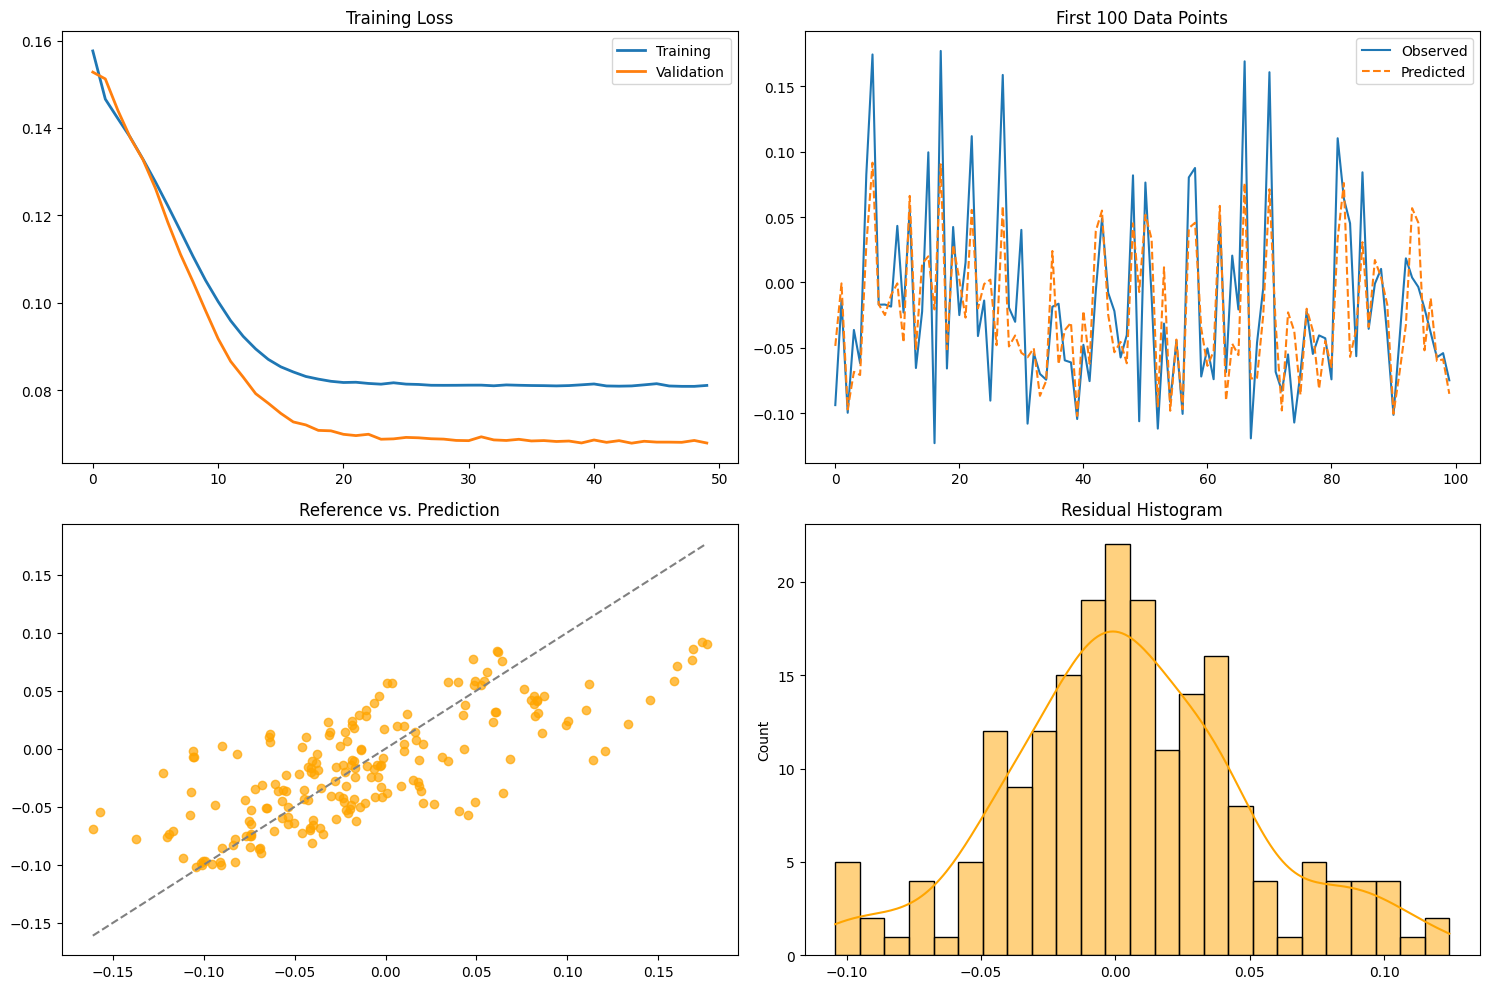


Performance Indicators:
  MSE:  0.0021
  RMSE: 0.0455
  MAE:  0.0347


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Neuro-Fuzzy Unit
class NeuroFuzzyUnit(nn.Module):
    def __init__(self, input_dim, n_nodes=3):
        super(NeuroFuzzyUnit, self).__init__()
        self.input_dim = input_dim
        self.n_nodes = n_nodes

        # Centroids, spreads, and linear coefficients
        self.centroids = nn.Parameter(torch.empty(input_dim, n_nodes))
        self.spreads = nn.Parameter(torch.empty(input_dim, n_nodes))
        self.coeffs = nn.Parameter(torch.empty(input_dim * n_nodes, 1))

        # Initialize parameters
        nn.init.xavier_uniform_(self.centroids)
        nn.init.ones_(self.spreads)
        nn.init.normal_(self.coeffs, std=0.01)

    def forward(self, x):
        # Expand dimensions
        x_exp = x.unsqueeze(2)
        centroids_exp = self.centroids.unsqueeze(0)

        # Compute RBF activation
        delta = x_exp - centroids_exp
        sigma = torch.abs(self.spreads) + 1e-3
        activations = torch.exp(-(delta ** 2) / (2 * sigma))

        # Flatten and apply linear combination
        flat_act = activations.view(x.size(0), -1)
        output = flat_act @ self.coeffs
        return output


# Neuro-Fuzzy Model
class NeuroFuzzyModel(nn.Module):
    def __init__(self, input_dim, n_nodes=3):
        super(NeuroFuzzyModel, self).__init__()
        self.neuro_fuzzy = NeuroFuzzyUnit(input_dim, n_nodes)

    def forward(self, x):
        return self.neuro_fuzzy(x)


# Create sequences for the data using a sliding window
def create_sequences(data, window_size):
    sequences, targets = [], []
    for idx in range(len(data) - window_size):
        seq = data[idx: idx + window_size, 0]
        label = data[idx + window_size, 1]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)


# Process the system
def process_system(data_file, window=3):
    try:
        # 1) Load data
        raw_data = np.loadtxt(data_file)
        print("Raw data shape:", raw_data.shape)

        # 2) Scale features
        scale_x = MinMaxScaler(feature_range=(-1, 1))
        scale_y = MinMaxScaler(feature_range=(-1, 1))

        data_scaled = np.zeros_like(raw_data)
        data_scaled[:, 0] = scale_x.fit_transform(raw_data[:, 0].reshape(-1, 1)).flatten()
        data_scaled[:, 1] = scale_y.fit_transform(raw_data[:, 1].reshape(-1, 1)).flatten()

        # 3) Create windowed sequences
        X, y = create_sequences(data_scaled, window)
        print("Windowed input shape:", X.shape)
        print("Windowed target shape:", y.shape)

        # 4) Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=13
        )

        # 5) Convert to torch tensors
        X_train_t = torch.from_numpy(X_train).float()
        y_train_t = torch.from_numpy(y_train).float().unsqueeze(-1)
        X_test_t  = torch.from_numpy(X_test).float()
        y_test_t  = torch.from_numpy(y_test).float().unsqueeze(-1)

        # 6) Build the model, define loss and optimizer
        model = NeuroFuzzyModel(window, n_nodes=3)
        loss_fn = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        # 7) DataLoaders
        train_set = TensorDataset(X_train_t, y_train_t)
        test_set = TensorDataset(X_test_t, y_test_t)

        train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
        val_loader   = DataLoader(test_set,  batch_size=32, shuffle=False)

        # 8) Training loop with early stopping
        max_epochs = 50
        patience = 10
        best_loss = np.inf
        no_improve_count = 0

        history = {'train_loss': [], 'val_loss': []}
        best_model_wts = None

        for epoch in range(max_epochs):
            model.train()
            total_train_loss = 0.0

            for bx, by in train_loader:
                optimizer.zero_grad()
                pred = model(bx)
                l = loss_fn(pred, by)
                l.backward()
                optimizer.step()
                total_train_loss += l.item() * bx.size(0)

            avg_train_loss = total_train_loss / len(train_loader.dataset)

            # Validation
            model.eval()
            total_val_loss = 0.0
            with torch.no_grad():
                for vx, vy in val_loader:
                    val_pred = model(vx)
                    v_loss = loss_fn(val_pred, vy)
                    total_val_loss += v_loss.item() * vx.size(0)

            avg_val_loss = total_val_loss / len(val_loader.dataset)

            # Save losses
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)

            print(f"Epoch [{epoch+1}/{max_epochs}] "
                  f"Train MSE: {avg_train_loss:.6f} | Val MSE: {avg_val_loss:.6f}")

            # Early Stopping Logic
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                best_model_wts = model.state_dict()
                no_improve_count = 0
            else:
                no_improve_count += 1
                if no_improve_count >= patience:
                    print("Early stopping reached.")
                    break

        # 9) Restore best weights
        if best_model_wts is not None:
            model.load_state_dict(best_model_wts)

        # 10) Evaluate
        model.eval()
        with torch.no_grad():
            predictions = model(X_test_t).cpu().numpy().flatten()

        # 11) Inverse transform
        true_vals = scale_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
        pred_vals = scale_y.inverse_transform(predictions.reshape(-1, 1)).flatten()

        # 12) Metrics
        residuals = true_vals - pred_vals
        mse_val = np.mean(residuals**2)
        rmse_val = np.sqrt(mse_val)
        mae_val = np.mean(np.abs(residuals))

        # 13) Plot results (changed style & text)
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Loss vs. Epoch
        axes[0, 0].plot(history['train_loss'], label='Training', linewidth=2)
        axes[0, 0].plot(history['val_loss'],   label='Validation', linewidth=2)
        axes[0, 0].set_title("Training Loss")
        axes[0, 0].legend()

        # Real vs. Prediction (first 100 points)
        axes[0, 1].plot(true_vals[:100], label='Observed')
        axes[0, 1].plot(pred_vals[:100], label='Predicted', linestyle='--')
        axes[0, 1].set_title("First 100 Data Points")
        axes[0, 1].legend()

        # Scatter: y_true vs y_pred
        axes[1, 0].scatter(true_vals, pred_vals, alpha=0.7, color='orange')
        min_all = min(true_vals.min(), pred_vals.min())
        max_all = max(true_vals.max(), pred_vals.max())
        axes[1, 0].plot([min_all, max_all], [min_all, max_all], color='gray', linestyle='--')
        axes[1, 0].set_title("Reference vs. Prediction")

        # Residual distribution
        sns.histplot(residuals, bins=25, kde=True, color='orange', ax=axes[1, 1])
        axes[1, 1].set_title("Residual Histogram")

        plt.tight_layout()
        plt.show()

        # 14) Print results
        print("\nPerformance Indicators:")
        print(f"  MSE:  {mse_val:.4f}")
        print(f"  RMSE: {rmse_val:.4f}")
        print(f"  MAE:  {mae_val:.4f}")

        return model, history, (mse_val, rmse_val, mae_val)

    except Exception as exc:
        print(f"Error: {exc}")
        return None, None, None


if __name__ == "__main__":
    print("Starting PyTorch-based processing...")
    data_file = 'ballbeam.dat'
    trained_model, log_dict, metrics = process_system(data_file)
